# `TauREx3` retrieval with a Madhu Seager 2009 Temperature Pressure Profile

*Author: Quentin Changeat (University College London, Space Telescope Science Institute) with Michelle Fabienne Bieger (University of Exeter)*

For this tutorial, you need:
- `TauREx3.1`. 
- `taurex-ace`.

These codes can be installed doing ``pip install taurex`` and ``pip install taurex-ace`` in a command line. Before doing this, we encourage you to create a new conda environment, which allows better control of the installed libraries and dependencies. Anaconda is available at: https://repo.anaconda.com/

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
# from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()

# Loading in the cross section and cia information: 
# Those are tables characterising the absorption of each species in the atmosphere
# They depends on wavelengths, temperature and pressure
from taurex.cache import OpacityCache,CIACache
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("/Users/mbieger/data/xsec/xsec_sampled_R15000_0.3-15")
CIACache().set_cia_path("/Users/mbieger/data/cia/HITRAN/data")
# Make sure to include your own path! 

Now we're going to import a planet and star profile.

In [3]:
# Planet 
from taurex.planet import Planet
planet = Planet(planet_radius=1.53,planet_mass=0.85, albedo=0)

# Star
from taurex.stellar import BlackbodyStar
star = BlackbodyStar(temperature=6600,radius=1.51)

Below, we're going to establish our new temperature-pressure profile, which will be following that of Madhusudhan and Seager 2009 (arXiv:0910.147v2).

In [3]:
from taurex.temperature import TemperatureProfile
import numpy as np
from taurex.data.fittable import fitparam
import scipy as sp
from taurex.exceptions import InvalidModelException

class InvalidTemperatureException(InvalidModelException): 
    """
    Exception, called when atmosphere mix is greater than unity
    """
    pass



class MadhuSeager2009(TemperatureProfile):
    """

    TP profile from Madhusudhan and Seager 2009, arXiv:0910.147v2

    Parameters
    -----------
        T_top: float
            temperature at the top of the atmosphere in Kelvin
        P_top: float
            pressure at the top of the atmosphere in Pascal (TauREx default)
        T_1,2,3: float
            temperature at Layer 1,2,3 (deepest layer) of the atmosphere in Kelvin
        P_1,2,3: float
            pressure at Layer 1,2,3 (deepest layer) of the atmosphere in Pascal (TauREx default)
        alpha_1,2: float
            multiplicative factor
            the lower the value the steeper the Layer 1 gradient
        beta_1,2: float
            multiplicative factor
            the lower the value the steeper the Layer 2 gradient
    """

    ### Initializing the new class
    def __init__(self, T_top = 1000, P_top = 1, T_1 = 1400, T_2 = 1100, T_3 = 1500, P_1 = 700, P_2 = 9000, P_3 = 1e5, alpha_1 = 50, alpha_2 =50, beta_1 = 0.5, beta_2 = 0.5):
        super().__init__('Madhuuuuuu')

        self.info('MadhuSeager2009 temperature profile initialised')
        self._T_top = T_top
        self._P_top = P_top
        self._T_1 = T_1
        self._T_2 = T_2 
        self._T_3 = T_3
        self._P_1 = P_1 
        self._P_2 = P_2 
        self._P_3 = P_3 
        self._alpha_1 = alpha_1
        self._alpha_2 = alpha_2 
        self._beta_1 = beta_1
        self._beta_2 = beta_2
    
    ### Defining the get and set function for the fitting parameter 'mean'
    @fitparam(param_name='T_top',
              param_latex='$T_{top}$',
              default_fit=False,
              default_bounds=[300.0,2000.0])
    def topTemperature(self):
        return self._T_top
    
    @topTemperature.setter
    def topTemperature(self, value):
        self._T_top = value
        
    @fitparam(param_name='P_top',
              param_latex='$P_{top}$',
              default_fit=False,
              default_bounds=[1,700])
    def topPressure(self):
        return self._P_top
    
    @topPressure.setter
    def topPressure(self, value):
        self._P_top = value
    
    @fitparam(param_name='alpha_1',
              param_latex= '$\\alpha_{1}$',
              default_fit=False,
              default_bounds=[0.15,0.35])
    def oneAlpha(self):
        return self._alpha_1
    
    @oneAlpha.setter
    def oneAlpha(self, value):
        self._alpha_1 = value
    
    # a note on the fitting boundaries
    # for alpha 2: madhu seager 2009
    # IRS data set constrains α2 to be greater than 0.2
    # broadband photometry data set constrains to be 0.18 - 0.35 
    # HST data set constrains to be 0.15 - 0.27
    
    @fitparam(param_name='alpha_2',
              param_latex= '$\\alpha_{2}$',
              default_fit=False,
              default_bounds=[0.15,0.35])
    def twoAlpha(self):
        return self._alpha_2
    
    @twoAlpha.setter
    def twoAlpha(self, value):
        self._alpha_2 = value
        
    @fitparam(param_name='T_1',
              param_latex='$T_{1}$',
              default_fit=False,
              default_bounds=[300.0,2000.0])
    def oneTemperature(self):
        return self._T_1
    
    @oneTemperature.setter
    def oneTemperature(self, value):
        self._T_1 = value
    
    @fitparam(param_name='T_2',
              param_latex='$T_{2}$',
              default_fit=False,
              default_bounds=[300.0,2000.0])
    def twoTemperature(self):
        return self._T_2
    
    @twoTemperature.setter
    def twoTemperature(self, value):
        self._T_2 = value
        
    @fitparam(param_name='T_3',
              param_latex='$T_{3}$',
              default_fit=False,
              default_bounds=[300.0,2000.0])
    def threeTemperature(self):
        return self._T_3
    
    @threeTemperature.setter
    def threeTemperature(self, value):
        self._T_3 = value
    
    @fitparam(param_name='P_1',
              param_latex='$P_{1}$',
              default_fit=False,
              default_bounds=[1e5,1])
    def onePressure(self):
        return self._P_1
    
    @onePressure.setter
    def onePressure(self, value):
        self._P_1 = value
    
    @fitparam(param_name='P_2',
              param_latex='$P_{2}$',
              default_fit=False,
              default_bounds=[1e5,1])
    def twoPressure(self):
        return self._P_2
    
    @twoPressure.setter
    def twoPressure(self, value):
        self._P_2 = value
        
    @fitparam(param_name='P_3',
              param_latex='$P_{3}$',
              default_fit=False,
              default_bounds=[1e5,1])
    def threePressure(self):
        return self._P_3
    
    @threePressure.setter
    def threePressure(self, value):
        self._P_3 = value
    
    ### The key of this class, this provides the temperature profile.
    ### This 'profile()' function is mandatory for all classes inheriting from the TemperatureProfile class.

    
    def check_profile(self,Ppt): 

         # P1 < P2 < P3 as a condition 
         # aka P_top < P_1 < P_2 < P_3 
        if not (any(Ppt[i] <= Ppt[i+1] for i in range(len(Ppt)-1))): 
            self.warning('Temperature profile is not valid! A pressure point is inverted.')
            raise InvalidTemperatureException

    
    @property
    def profile(self):
        """Returns stratified pressure-temperature layer with two constraints of continuity at the two layer boundaries, i.e., Layers 1–2 and Layers 2–3
        """

        self._T_2 = self._T_top + np.power( (1/self._alpha_1)*np.log(self._P_1/self._P_top) , 1/self._beta_1) - np.power( (1/self._alpha_2)*np.log(self._P_1/self._P_2) , 1/self._beta_2)
        self._T_3 = self._T_2 + np.power( (1/self._alpha_2)*np.log(self._P_3/self._P_2) , 1/self._beta_2)
        # continuity conditions from MaduSeager 2009
        
        P = self.pressure_profile
        T = np.zeros((self.nlayers))

        less_P = [self._P_top,self._P_1,self._P_2,self._P_3]
#         print(less_P)
        self.check_profile(less_P)
        # check that P, T still viable
    
        for i, p in enumerate(P):
            if (p > self._P_top ) and (p < self._P_1):
                T[i] = self._T_top + np.power( (1/self._alpha_1)*np.log(p/self._P_top) , 1/self._beta_1)
            elif (p > self._P_1) and (p < self._P_3):
                T[i] = self._T_2 + np.power( (1/self._alpha_2)*np.log(p/self._P_2) , 1/self._beta_2)
            elif (p > self._P_3):
                T[i] = self._T_3
            else:
                T[i] = self._T_top
                # isothermal in deepest layers of atm
            
        return T
    

    ### This is to tell TauREx what outputs to save
    def write(self, output):
        temperature = super().write(output)
        temperature.write_scalar('T_top', self._T_top)
        temperature.write_scalar('P_top', self._P_top)
        temperature.write_scalar('T_1', self._T_1)
        temperature.write_scalar('T_2', self._T_2)
        temperature.write_scalar('T_3', self._T_3)
        temperature.write_scalar('P_1', self._P_1)
        temperature.write_scalar('P_2', self._P_2)
        temperature.write_scalar('P_3', self._P_3)
        temperature.write_scalar('alpha_1', self._alpha_1)
        temperature.write_scalar('alpha_2', self._alpha_2)
        temperature.write_scalar('beta_1', self._beta_1)
        temperature.write_scalar('beta_2', self._beta_2)
        return temperature

    ### This is the keyword to use in the parfile
    @classmethod
    def input_keywords(cls):
        return ['MadhuSeager2009', 'madhuseager2009']

Now we need to call it, and define values for it for our planet. 

In [5]:
temp = MadhuSeager2009(T_top = 1000, 
                      P_top = 1e-5, # 1 Pa is 1e-5 bar
                      T_1 = 1600, 
                      T_2 = 1500, 
                      T_3 = 2000, 
                      P_1 = 0.0309,
                       # 700
                      P_2 = 229,
                       # 9e3
                      P_3 = 6.456,
                       # 1e5
                      alpha_1 = 0.7, # the lower the value the steeper the Layer 1 gradient
                      alpha_2 =0.2, # the lower the value the steeper the Layer 2 gradient 
                      beta_1 = 0.5, 
                      beta_2 = 0.5)

Let's add some chemistry into the mix! 

In [6]:
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=[0.17,])
# Creating a mostly H2/He atmosphere

from taurex.chemistry import ConstantGas
from taurex.chemistry import TwoLayerGas
chemistry.addGas(ConstantGas('H2O',mix_ratio=1e-5))
chemistry.addGas(ConstantGas('CH4',mix_ratio=1e-2))
chemistry.addGas(ConstantGas('CO2',mix_ratio=1e-6))
chemistry.addGas(ConstantGas('CO',mix_ratio=1e-2))
chemistry.addGas(ConstantGas('N2',mix_ratio=1e-2))

from taurex_ace import ACEChemistry
chemistry = ACEChemistry(metallicity=1, co_ratio=0.55)

print('Active gases:', chemistry.activeGases)
print('Inactive gases (only the first 5):', chemistry.inactiveGases[:5])
print('Number of species included: ', len(chemistry.gases))

Active gases: ('CO2', 'NH3', 'CH4', 'CO', 'H2O')
Inactive gases (only the first 5): ('CH3COOOH', 'C4H9O', 'C3H7O', 'NO3', 'CH3COOO')
Number of species included:  105


So we've established a planet, with a host star, set-up a TP profile and thrown some chemistry in the mix. Let's model it as a transmission spectra now!

In [7]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=temp,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-1,
                       atm_max_pressure=1e6,
                       nlayers=100)

And add more physical processes in to it: absorption, CIA contributions, Rayleigh scattering, and some clouds! 

In [8]:
# Add absorption contributions
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

# Add cia contributions
from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

# Add Rayleigh contributions
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

# Add clouds contribution. Clouds pressure is in Pa
from taurex.contributions import SimpleCloudsContribution
tm.add_contribution(SimpleCloudsContribution(clouds_pressure=1e4))

Now we need to build this transmission model up: 

In [9]:
tm.build()

InvalidModelException: Nans produced using parameters Z: 1 CO: 0.55

Now that it's built, we can see what kind of fitting parameters we have for this model, that we can then pass on to a retrieval! 

In [10]:
print('List of fittingParameters:', tm.fittingParameters.keys())

List of fittingParameters: dict_keys(['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'T_top', 'P_top', 'alpha_1', 'alpha_2', 'T_1', 'T_2', 'T_3', 'P_1', 'P_2', 'P_3', 'ace_metallicity', 'metallicity', 'ace_co', 'C_O_ratio', 'clouds_pressure'])


In [11]:
res = tm.model()

Let's plot out the temperature-pressure profile, by first retrieving the profile from the transmission model we built, and then plotting it. 

In [12]:
tp = tm.temperatureProfile
pr = tm.pressureProfile

<IPython.core.display.Javascript object>


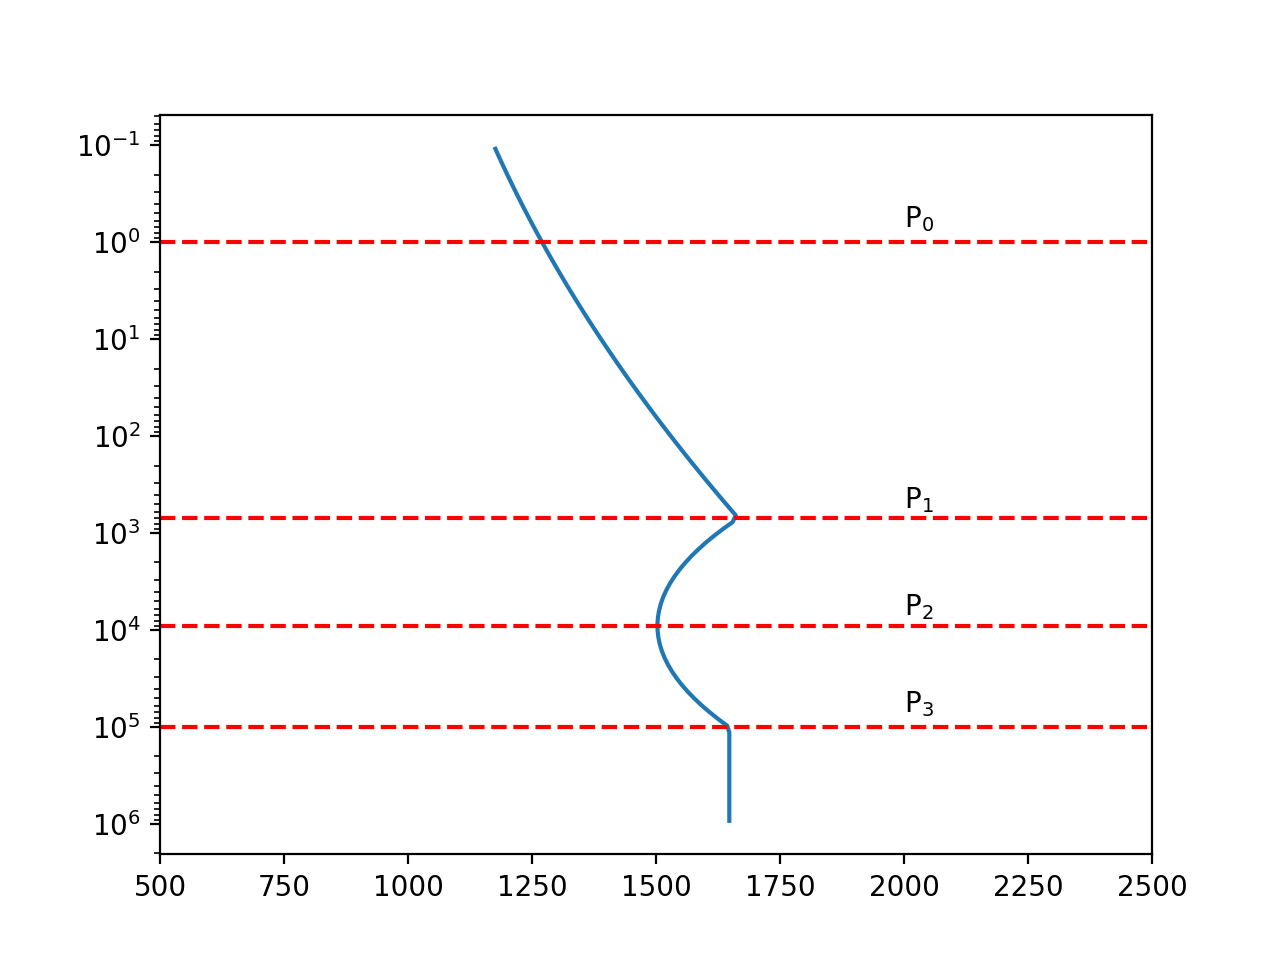

In [13]:
plt.figure()
plt.plot(tp, pr)
# use ,marker='.' in plot to include dots and investigate boundary layers
plt.yscale('log')
plt.gca().invert_yaxis()
plt.xlim((500,2500))
plt.axhline(1,ls='--',c='red')
plt.text(x=2000,y=0.7,s=r'$\mathrm{P}_0$')
plt.axhline(700,ls='--',c='red')
plt.text(x=2000,y=550,s=r'$\mathrm{P}_1$')
plt.axhline(9e3,ls='--',c='red')
plt.text(x=2000,y=7000,s=r'$\mathrm{P}_2$')
plt.axhline(1e5,ls='--',c='red')
plt.text(x=2000,y=70000,s=r'$\mathrm{P}_3$')
plt.show()

### Plot the model

The results are stored in the variable ``res``. We can unpack this tuple and do a simple plot of the spectrum. 
In TauREx, the units for wavelength is wavenumber, but you might be more familiar with wavelength, so we can convert before plotting.

In [ ]:
native_grid, rprs, tau, _ = res
# Native grid is in wavenumber by convention. But let's convert to wavelengths:
native_grid_wl = 10000/native_grid

plt.figure()
plt.plot(native_grid_wl, rprs, color='blue')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (%)')
plt.xlim(0.5, 2)
plt.show()

The result of the forward model is provided at native resolution, and it can be hard to see what is going on here. To work at a lower resolution, we can bin down the result using convenient functions from ``TauREx``. Let's start by getting a new wavelength grid at resolution 80 between 1.1 and 1.6um, with the ``create_grid_res`` function. This is as simple as:

In [ ]:
from taurex.util.util import create_grid_res
lowres_grid = create_grid_res(80, 1.1, 1.6)

We can now use the ``FluxBinner`` to bin down our high resolution spectrum to this new grid. We first initialise the binner, passing in the wavelength and binwidth grids:

In [ ]:
from taurex.binning import FluxBinner
fb = FluxBinner(lowres_grid[:,0], lowres_grid[:,1])

The binner can then be used on the high resolution spectrum via the ``bindown()`` function. There is also a ``bin_model()`` function, which takes in the results of the ``model()`` (here it would be res). For the ``bindown()`` function, quantities must be sorted in incresing wavelengths:

In [ ]:
lowres_spectrum = fb.bindown(native_grid_wl[::-1], rprs[::-1])

In [ ]:
# Now a small plot to check we do this right:
plt.figure()
plt.plot(native_grid_wl, rprs, color='blue',alpha=0.1, label='High resolution spectrum')
plt.plot(lowres_spectrum[0], lowres_spectrum[1], color='orange', label='Low resolution spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (%)')
plt.legend()
plt.xlim(1.0,1.8)
plt.show()

All quantities of interest can be extracted from the model directly. For example, if we want to plot the temperature profile we just used:

In [ ]:
activechemistry = tm.chemistry.activeGasMixProfile
inactivechemistry = tm.chemistry.inactiveGasMixProfile
pressure = tm.pressure.profile
temperature = tm.temperature.profile

fig, ax = plt.subplots(figsize=(5,5))

## iterate over the active gases
for index, gas in enumerate(tm.chemistry.activeGases):
    ax.plot(activechemistry[index, :], pressure,'-', label = gas)
    
## iterate over the inactive gases. 
for index, gas in enumerate(tm.chemistry.inactiveGases):
    if gas in ['H2', 'He']:
        ax.plot(inactivechemistry[index, :], pressure,'-', label = gas)
    # You can also add all molecules, without labels !
 #   else:
 #       ax.plot(inactivechemistry[index, :], pressure,'--', alpha = 0.3)
    
ax2=ax.twiny()
ax2.plot(temperature, pressure,'-.', color = 'firebrick', linewidth=3, label = 'Temperature')

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-15, 1)
ax.set_ylim(1e6, 1e-1)
ax.set_xlabel('Volume Mixing Ratio')
ax.set_ylabel('Pressure (Pa)')

ax2.legend(loc="lower right")
ax2.set_xlabel('Temperature (K)')
#plt.gca().invert_yaxis()
# plt.savefig('Outputs/my_forward_chemistry.pdf', bbox_inches='tight')
plt.show()

We can do retrievals with this profile in a Jupyter Notebook or on a local command line, but to see how to use retrievals with this profile in a .par file on a computer cluster or server, please see the markdown READ.me. Note that in order to keep consistent to the MadhuSeager2009 PT profile as described in the 2009 publication, when retrieving you should not fit for P_top, T_2, or T_3. 